In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [23]:
class Stock:
    def __init__(self , ticker , period , start , end):
        self.ticker = ticker
        self.period = period
        self.start = start
        self.end = end
        self.Ex_Shortfall = lambda changes , conf : np.mean(changes[changes > np.percentile(-1 * changes, conf * 100)])

    #  سود محاسبه میکنه
    def returns_period(self):
        data = yf.download(self.ticker , start = self.start , end = self.end)
        list_changes_peroid = []
        for i in range(0 , data.shape[0] , self.period):
            try:
                list_changes_peroid.append((data['Close'].iloc[i + self.period] - data['Close'].iloc[i]).values)
            except IndexError :
                pass
        list_changes_peroid = np.array(list_changes_peroid)
        return list_changes_peroid

    def show_details(self , bounds):
        list_changes = self.returns_period()
        print(f'Mean : {np.mean(list_changes)} , Median : {np.median(list_changes)} , Std : {np.std(list_changes)}')
        x = np.linspace(np.min(list_changes) , np.max(list_changes) , 25)
        bin_width = (x[1] - x[0])
        y = norm.pdf(x, np.mean(list_changes), np.std(list_changes)) * list_changes.shape[0] * bin_width
        # با کم و زیاد کردن مقدار bounds  میتوانیم یک ترید آف بین اورفیت شدن و آندرفیت بودن تابع برقرار کنیم
        kde = gaussian_kde(list_changes.flatten() , bw_method = bounds )
        y2 = kde(x)
        y_scaled = y2 * list_changes.shape[0] * (x[1] - x[0])
        fig , axes = plt.subplots(1 , 3 , figsize = (14,5))
        axes[0].hist(self.returns_period() , bins=25)
        axes[0].plot(x , y , label= 'Normal Distribution')
        axes[0].plot(x , y_scaled , label="KDE")
        axes[0].axvline(np.mean(list_changes) , color = 'red' , label = 'Mean' , linestyle = '--')
        axes[0].set_label('Mean')
        axes[0].axvline(np.median(list_changes) , color = 'blue' , label = 'Median' , linestyle = '--')
        
        axes[1].plot(self.show_Loss_dist(self.returns_period())[0] , self.show_Loss_dist(self.returns_period())[1] , label='PDF', color='blue')
        axes[1].grid(True)
        axes[1].set_title('Loss distribution')
        axes[1].set_xlabel('Values')
        axes[1].set_ylabel('Density')
        list_confidence = []
        list_Expected_shortfall = []
        for conf_level in np.arange(0.5 , 1 , 0.01):
            list_confidence.append(conf_level)
            list_Expected_shortfall.append(self.Ex_Shortfall(list_changes , conf_level))
            # print(f"for confidence Level {round(conf_level,2)} Expected Shortfall is {round(self.Ex_Shortfall(list_changes , conf_level) , 2)} and VaR is {-1 * np.percentile(-1 * list_changes, (1 - conf_level) * 100)}")
            
        axes[2].plot(list_confidence , list_Expected_shortfall)
        axes[2].grid(True)
        axes[2].set_title('Expected Shortfall')
        axes[2].set_xlabel('Confidence Level')
        axes[2].set_ylabel('Expected Shortfall')

    def show_Loss_dist(self , changes):
        mean_loss = -1 * np.mean(changes)
        std_dev = np.std(changes)
        range_loss = np.arange(0,1,0.01)
        list2 = []
        for i in range_loss:
            list2.append(np.percentile(changes , (1 - i) * 100))
            # list2.append(norm.ppf(i, loc=mean_loss, scale=std_dev))
        list2 = list2[::-1]
        values = list2
        probabilities = 1 - range_loss
        probabilities = np.array(probabilities[1:])
        values = np.array(values[1:])

        pdf = -np.diff(probabilities) / np.diff(values) 
        x = (values[:-1] + values[1:]) / 2 
        return x , pdf
        
        
class Portofolio(Stock):
    def __init__(self, ticker, weights, period, start, end):
        super().__init__(ticker=ticker[0], period=period, start=start, end=end)
        self.tickers = ticker
        self.weights = weights

    def returns_period_all(self):
        ret_all = []
        for i in range(len(self.tickers)):
            self.ticker = self.tickers[i]  
            ret_all.append(self.returns_period())
        ret_all = np.array(ret_all)
        new_changes = np.ndarray.flatten(ret_all)
        new_changes = new_changes.reshape(len(self.tickers), int(len(new_changes) / len(self.tickers)))
        final_result = self.weights @ new_changes
        final_result = final_result.reshape(-1, 1)
        return final_result

for MSFT

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Mean : 0.19236738169541093 , Median : 0.21500015258789062 , Std : 4.071830327694241



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


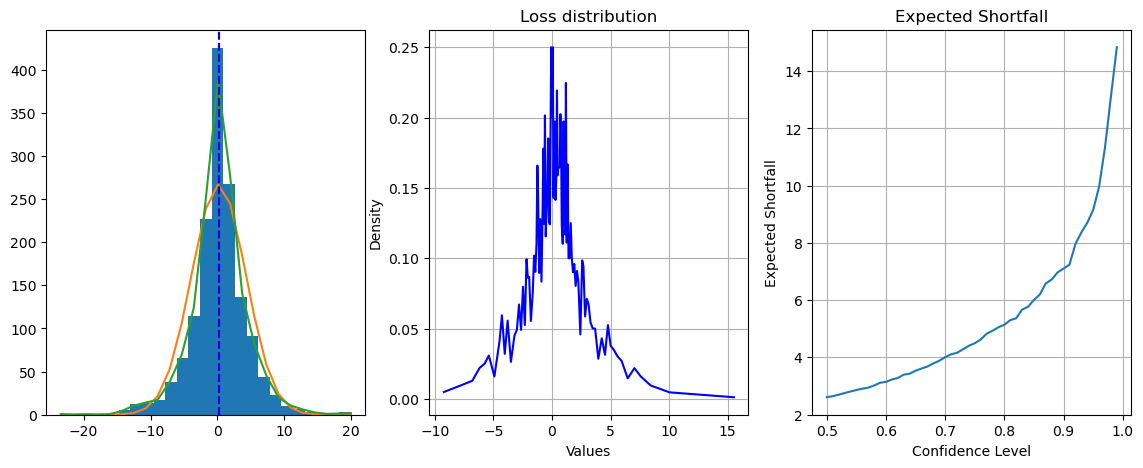

In [24]:
# for one stock
msft = Stock('MSFT' , 1 , '2018-01-01' , '2024-01-01')
msft.show_details(0.25)

for portofolio

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Mean : 0.09911472158659675 , Median : 0.10000038146972656 , Std : 2.212024988295786



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


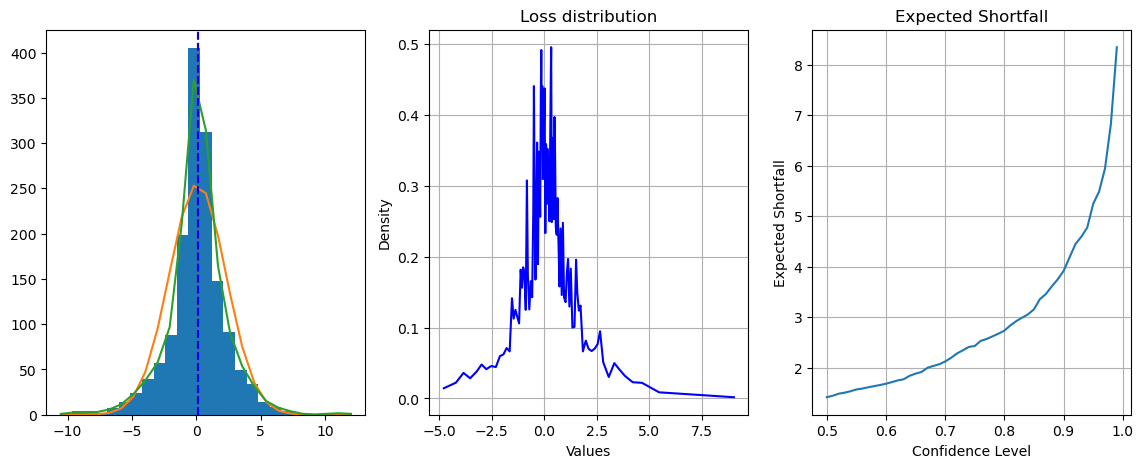

In [25]:
my_stocks = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]
weights = np.array([0.1 , 0.1 , 0.2 , 0.3 , 0.1])

stocks = Portofolio(my_stocks , weights , 1 , '2018-01-01' , '2024-01-01')
stocks.show_details(0.25)